In [1]:
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse('export.xml') 
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [3]:
for record in record_list[:5]: 
    print(record)

{'type': 'HKQuantityTypeIdentifierBodyMassIndex', 'sourceName': 'Health', 'sourceVersion': '14.3', 'unit': 'count', 'creationDate': '2021-01-23 17:41:19 +0000', 'startDate': '2021-01-23 17:41:00 +0000', 'endDate': '2021-01-23 17:41:00 +0000', 'value': '27.43'}
{'type': 'HKQuantityTypeIdentifierBodyMassIndex', 'sourceName': 'Withings', 'sourceVersion': '5130104', 'unit': 'count', 'creationDate': '2023-01-12 18:43:31 +0000', 'startDate': '2023-01-12 18:42:13 +0000', 'endDate': '2023-01-12 18:42:13 +0000', 'value': '28.075'}
{'type': 'HKQuantityTypeIdentifierHeight', 'sourceName': 'Paul’s IPhone 13', 'sourceVersion': '15.2.1', 'unit': 'cm', 'creationDate': '2022-01-22 16:04:04 +0000', 'startDate': '2022-01-22 16:04:04 +0000', 'endDate': '2022-01-22 16:04:04 +0000', 'value': '174'}
{'type': 'HKQuantityTypeIdentifierHeight', 'sourceName': 'Health', 'sourceVersion': '9.2.1', 'unit': 'cm', 'creationDate': '2016-03-17 17:39:53 +0000', 'startDate': '2016-03-17 17:39:00 +0000', 'endDate': '2016-

In [4]:
#%run -i 'apple-health-data-parser' 'export.xml'

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
activity_summary = pd.read_csv('ActivitySummary.csv')
activity_summary.head()

,dateComponents,activeEnergyBurned,activeEnergyBurnedGoal,activeEnergyBurnedUnit,appleExerciseTime,appleExerciseTimeGoal,appleStandHours,appleStandHoursGoal
0,2021-11-20,0.000,0,kcal,0,30,0,12
1,2021-11-21,0.000,0,kcal,0,30,0,12
2,2022-01-21,0.000,0,kcal,0,30,0,12
3,2022-01-22,134.935,650,kcal,0,30,6,12
4,2022-01-23,1154.850,650,kcal,130,30,18,12


In [3]:
activity_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dateComponents          790 non-null    object 
 1   activeEnergyBurned      790 non-null    float64
 2   activeEnergyBurnedGoal  790 non-null    int64  
 3   activeEnergyBurnedUnit  790 non-null    object 
 4   appleExerciseTime       790 non-null    int64  
 5   appleExerciseTimeGoal   790 non-null    int64  
 6   appleStandHours         790 non-null    int64  
 7   appleStandHoursGoal     790 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 49.5+ KB


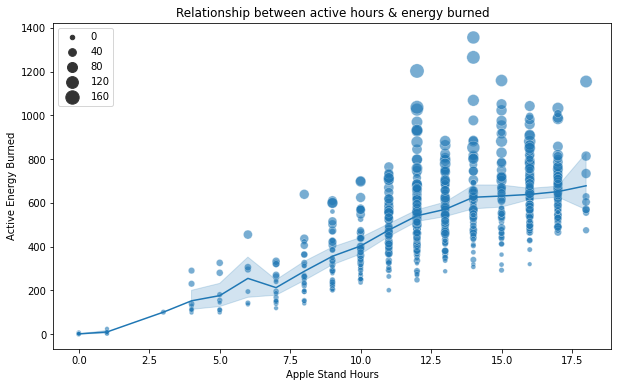

In [4]:
df = activity_summary[['appleStandHours', 'activeEnergyBurned', 'appleExerciseTime']]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='appleStandHours', y='activeEnergyBurned', size='appleExerciseTime', sizes=(20, 200), alpha=0.6)
sns.lineplot(data=df, x='appleStandHours', y='activeEnergyBurned')

plt.title('Relationship between active hours & energy burned')
plt.xlabel('Apple Stand Hours')
plt.ylabel('Active Energy Burned')
plt.show()

We observe a positive correlation between the amount of energy burned and the duration of standing hours (StandHours), suggesting that individuals tend to burn more energy when they are physically active. Additionally, there is a positive relationship between energy burned and exercise time (ExerciseTime), although this association may not always hold true. Therefore, recording activity levels during periods of high ExerciseTime and EnergyBurned, as well as during high ExerciseTime but low EnergyBurned, can provide valuable insights for modeling these relationships more accurately.

Alternatively, using time as a proxy for the type of exercise can also provide valuable context. For instance, categorizing morning activities as cycling and evening routines as cycling followed by gym sessions can enhance our understanding of progression of heart rate over years

In [38]:
workout_data = pd.read_csv('Workout.csv')
heart_rate_data = pd.read_csv('HeartRate.csv')


activity_summary['startDate'] = activity_summary['dateComponents']
workout_data['startDate'] = pd.to_datetime(workout_data['startDate'])
activity_summary['startDate'] = pd.to_datetime(activity_summary['startDate'])

workout_data['startDate'] = pd.to_datetime(workout_data['startDate']).dt.date
workout_data['startDate']=pd.to_datetime(workout_data['startDate'])


merged_data1 = pd.merge(workout_data, activity_summary, on='startDate', how='inner')

heart_rate_data['startDate'] = pd.to_datetime(heart_rate_data['startDate']).dt.date
heart_rate_data['startDate']=pd.to_datetime(heart_rate_data['startDate'])

merged_data2 = pd.merge(merged_data1, heart_rate_data, on='startDate', how='inner')

In [39]:
merged_data2['workoutActivityType'] = merged_data2['workoutActivityType'].replace({
    'HKWorkoutActivityTypeWalking': 'Walking',
    'HKWorkoutActivityTypeCycling': 'Cycling'
})

In [40]:
#Encode Cycling:0 and Walking:1
merged_data2['workoutActivityType1']=merged_data2['workoutActivityType']
merged_data2['workoutActivityType1'] = merged_data2['workoutActivityType1'].replace({'Cycling': 0, 'Walking': 1})

In [41]:
X = merged_data2[[ 'duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]
y = merged_data2['value'].values
dates = merged_data2['startDate']

In [51]:
X 

,duration,activeEnergyBurned,appleExerciseTime,workoutActivityType1
0,35.725322,1154.850,130,1
1,35.725322,1154.850,130,1
2,35.725322,1154.850,130,1
3,35.725322,1154.850,130,1
4,35.725322,1154.850,130,1
...,...,...,...,...
172270,12.852439,667.504,66,0
172271,12.852439,667.504,66,0
172272,12.852439,667.504,66,0
172273,12.852439,667.504,66,0


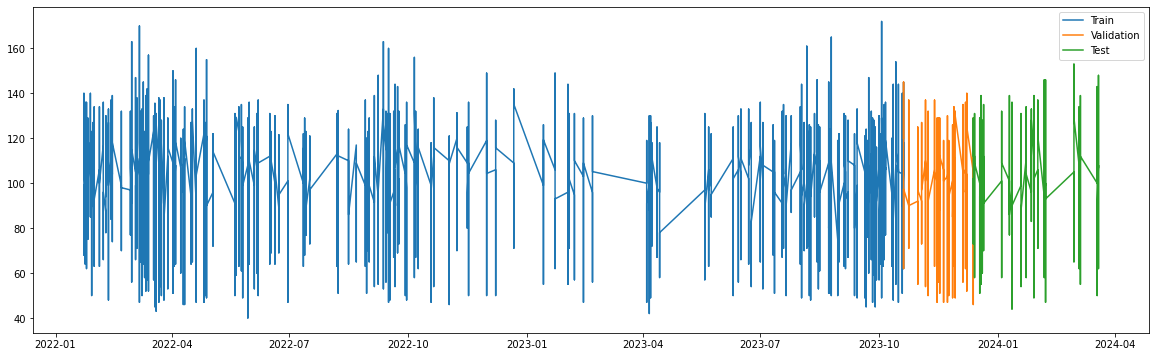

In [74]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

We observe a gradual decline in heart rate with age, a natural phenomenon influenced by various physiological changes. However, engaging in regular exercise can help maintain heart health and mitigate this decline. By staying physically active, individuals can support their cardiovascular system, ensuring that their heart rate remains within healthy ranges despite the aging process.

In [43]:
data=merged_data2[['duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1','value']]
target=data.value
covs=merged_data2[['duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]

In [53]:
from sklearn import linear_model

#Lets try to smooth the heart rate data by adjusting for exercise time, type of activity and duration
def regressOut(y, X, use_fit=None):
    lm = linear_model.LinearRegression()    
    if use_fit is None:
        use_fit = [True] * X.shape[0]
    else:
        use_fit = use_fit.values

    x_mean = X.iloc[use_fit,:].mean()
    lm.fit(X.loc[use_fit,:].values, y.loc[use_fit])
    yhat = lm.predict(X.values)
    res = y - yhat
    offset = lm.predict(x_mean.values.reshape(1, -1))
    return(res + offset)

In [54]:
data_regress = data.apply(lambda target: regressOut(target, covs))

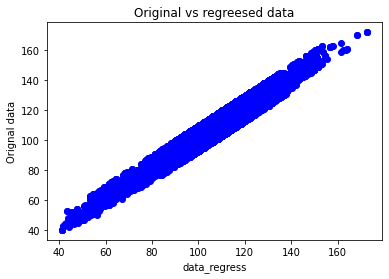

In [55]:
# Plot scatter plot
plt.scatter(data_regress.value, merged_data2.value, color='blue')
plt.xlabel('data_regress')
plt.ylabel('Orignal data')
plt.title('Original vs regreesed data')
plt.show()

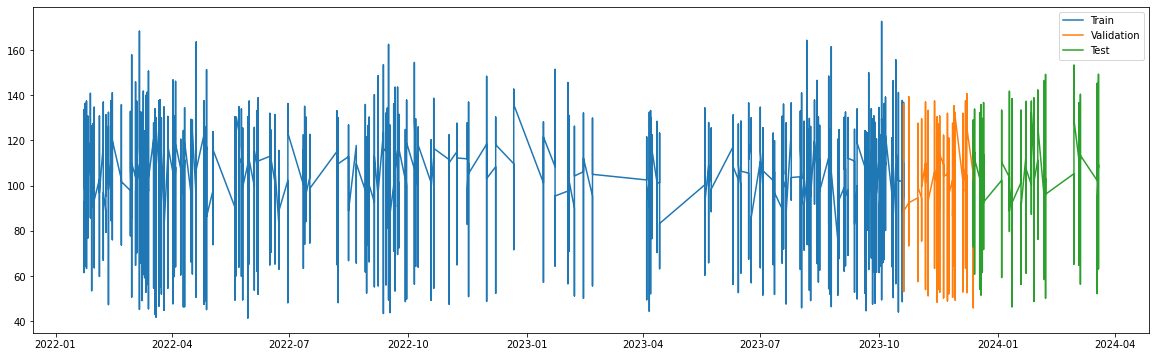

In [56]:
X_regr = data_regress[[ 'duration', 'activeEnergyBurned', 'appleExerciseTime','workoutActivityType1']]
y_regr = data_regress['value'].values
dates_regr = merged_data2['startDate']

dates_train_regr, X_train_regr, y_train_regr = dates_regr[:q_80], X_regr[:q_80], y_regr[:q_80]
dates_val_regr, X_val_regr, y_val_regr = dates_regr[q_80:q_90], X_regr[q_80:q_90], y_regr[q_80:q_90]
dates_test_regr, X_test_regr, y_test_regr = dates_regr[q_90:], X_regr[q_90:], y_regr[q_90:]

plt.figure(figsize=(20, 6))
plt.plot(dates_train_regr, y_train_regr)
plt.plot(dates_val_regr, y_val_regr)
plt.plot(dates_test_regr, y_test_regr)

plt.legend(['Train', 'Validation', 'Test'])

In [98]:
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


label_encoder = LabelEncoder()
scaler = StandardScaler()
X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']] = scaler.fit_transform(X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']])

# Convert DataFrame to numpy array
X_train = X_train.values
X_test=X_test.values

# Reshape X_train to add the third dimension
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))

/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_52147/3998542774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']] = scaler.fit_transform(X_train[['duration', 'activeEnergyBurned', 'appleExerciseTime']])


In [99]:

model = Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # Specify input shape
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
4307/4307 [==============================] - 10s 2ms/step - loss: 494.9711 - mean_absolute_error: 13.3079 - val_loss: 1464.4532 - val_mean_absolute_error: 35.5906
Epoch 2/100
4307/4307 [==============================] - 8s 2ms/step - loss: 155.9007 - mean_absolute_error: 9.9524 - val_loss: 1256.3409 - val_mean_absolute_error: 32.5471
Epoch 3/100
4307/4307 [==============================] - 8s 2ms/step - loss: 155.4081 - mean_absolute_error: 9.9431 - val_loss: 550.6743 - val_mean_absolute_error: 20.4382
Epoch 4/100
4307/4307 [==============================] - 8s 2ms/step - loss: 155.0055 - mean_absolute_error: 9.9272 - val_loss: 488.5211 - val_mean_absolute_error: 18.9593
Epoch 5/100
4307/4307 [==============================] - 8s 2ms/step - loss: 154.8038 - mean_absolute_error: 9.9181 - val_loss: 205.4394 - val_mean_absolute_error: 11.4187
Epoch 6/100
4307/4307 [==============================] - 7s 2ms/step - loss: 154.6441 - mean_absolute_error: 9.9148 - val_loss: 591.7721

4307/4307 [==============================] - 4s 908us/step


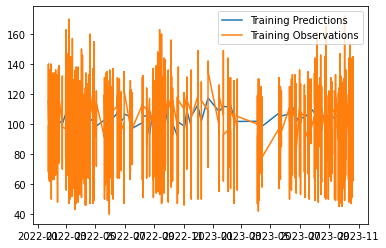

In [103]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

539/539 [==============================] - 0s 869us/step


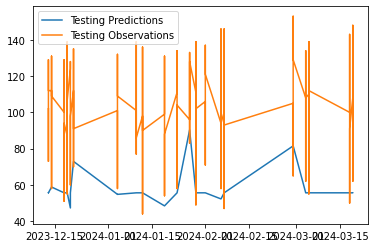

In [102]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])